## Second task

Скачайте датасет с kaggle-соревнования Kaggle: Facial Keypoints Detection
Задетектируйте при помощи выбранного выше landmark-детектора точки на лицах из этого датасета и посчитайте метрики для Ground-Truth точек которые эквивалентны точкам из модели (в opencv 68-point модель, в kaggle разметка для 15-точек.

Подумайте, предложите метрики, которые стоит посчитать для этой задачи. Мы хотим при помощи этих метрик оценить несколько факторов:
* оценить точность детектирования каждой из точек и всех точек в среднем
* оценить точность позиционирования (насколько точки смещаются относительно GT) для каждой landmark и в среднем

Отберите и визуализируйте (изображение + точки Ground Truth + Predicts) 3-5 изображений с самым высоким качеством детектирования и с самым низким.

### Метрики, которые решила использовать
Для оценки точности детектирования каждой из точек и всех точек в среднем я решила использовать
 * RMSE, MAE, NME - чтобы понимать насколько предсказанные и эталонные точки отклоняются друг от друга
 * Percentage of correct keypoints - чтобы оценить коректность предсказания с учетом порога ошибки

Для оценки точности позиционирования решила использовать смещение точек по осям и среднее смещение по осям

In [2]:
import zipfile
from tqdm import tqdm

import cv2
import dlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [2]:
with zipfile.ZipFile("kaggle/training.zip") as zip_h:
    zip_h.extractall("kaggle")

In [5]:
def string_to_image(image_str):
    image = np.fromiter(map(float, image_str.split()), dtype=np.uint8)
    image = image.reshape(96, 96)
    return image

In [6]:
training_csv = "kaggle/training.csv"
df = pd.read_csv(training_csv)
df.dropna(inplace=True)
df["image_r"] = df["Image"].apply(string_to_image)

In [7]:
def detect_landmarks(image_from_str: str) -> list:
    img_rgb = cv2.cvtColor(image_from_str, cv2.COLOR_BGR2RGB)
    faces = detector(img_rgb)
    if len(faces) == 0:
        return None
    shape = predictor(image, faces[0])
    landmarks = [(shape.part(i).x, shape.part(i).y) for i in range(68)]
    return landmarks


def calculate_metrics(
    detected_landmarks: np.array,
    control_points: np.array,
    threshold: float = 0.05,
) -> tuple:
    errors = []
    shifts = []
    for ctrl_pt in control_points:
        distances = np.linalg.norm(detected_landmarks - ctrl_pt, axis=1)
        min_dist = np.min(distances)
        errors.append(min_dist)

        shift_x = min_dist - ctrl_pt[0]
        shift_y = min_dist - ctrl_pt[1]
        shifts.append((shift_x, shift_y))
        
    rmse = np.sqrt(np.mean(np.array(errors) ** 2))
    mae = np.mean(errors)

    normalization_factor = max(errors)

    nme = np.mean(errors / normalization_factor)
    pck = np.mean(errors < (threshold * normalization_factor))

    shifts_x, shifts_y = zip(*shifts)
    mean_shift_x = np.mean(shifts_x)
    mean_shift_y = np.mean(shifts_y)

    return rmse, mae, nme, pck, mean_shift_x, mean_shift_y


def visualize_samples(
    image: str,
    detected_landmarks: np.array,
    control_points: np.array,
) -> None:
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')

    plt.scatter(*zip(*detected_landmarks), s=10, c="blue", label="Pred", marker="x")
    plt.scatter(*zip(*control_points), s=20, c="green", label="GT", marker="o")

    plt.axis("off")
    plt.show()

In [8]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [9]:
results = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    image = row["image_r"]
    detected_landmarks = detect_landmarks(image)
    if detected_landmarks is None:
        continue
    control_points = [
        (row[feature], row[feature.replace("_x", "_y")])
        for feature in df.columns[:-2:2]
    ]
    
    detected_landmarks = np.array(detected_landmarks)
    control_points = np.array(control_points)
    rmse, mae, nme, pck, mean_shift_x, mean_shift_y = calculate_metrics(detected_landmarks, control_points)
    results.append((i, rmse, mae, nme, pck, mean_shift_x, mean_shift_y))

100%|███████████████████████████████████| 2140/2140 [00:06<00:00, 332.24it/s]


Best Predictions
Image 1640
RMSE: 1.336, MAE: 1.062, NME: 0.424
PCK: 0.067
Mean shift X: -49.156, Mean shift Y: -47.214


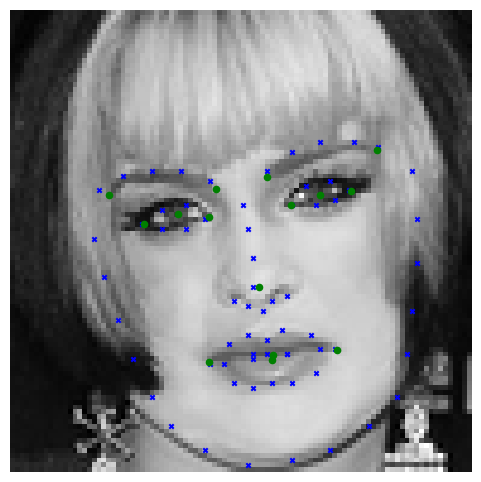

Image 2045
RMSE: 1.346, MAE: 1.152, NME: 0.469
PCK: 0.000
Mean shift X: -46.502, Mean shift Y: -45.542


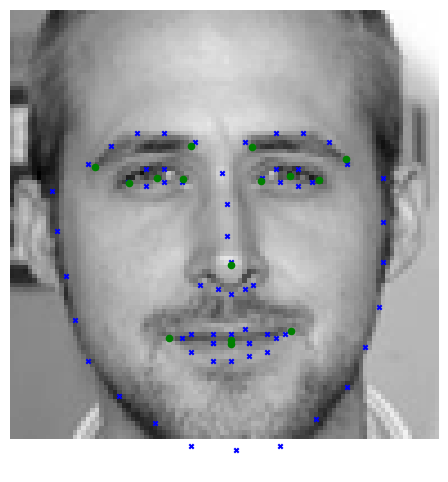

Image 1681
RMSE: 1.358, MAE: 1.167, NME: 0.408
PCK: 0.000
Mean shift X: -46.266, Mean shift Y: -45.891


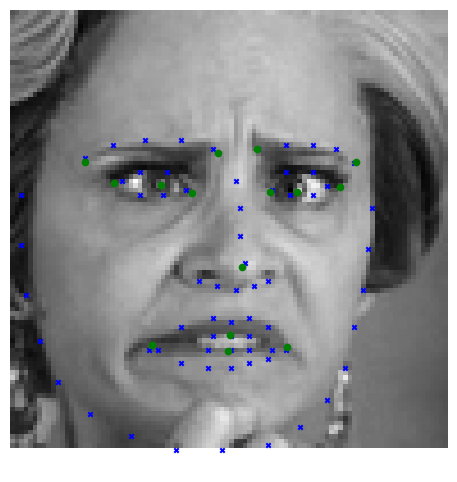

Worst Predictions
Image 2159
RMSE: 4.464, MAE: 3.636, NME: 0.311
PCK: 0.000
Mean shift X: -44.785, Mean shift Y: -44.364


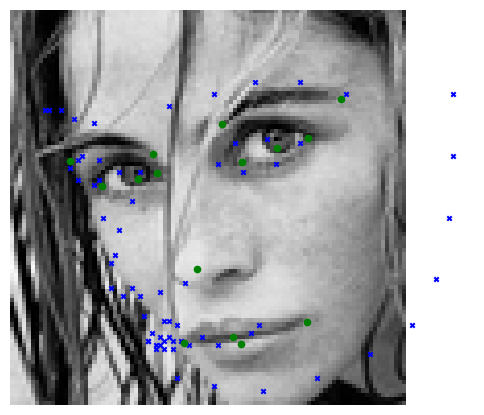

Image 1932
RMSE: 4.556, MAE: 3.811, NME: 0.505
PCK: 0.000
Mean shift X: -45.319, Mean shift Y: -49.081


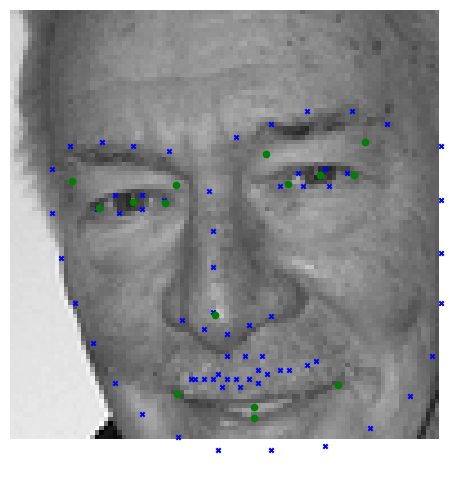

Image 1953
RMSE: 7.733, MAE: 6.809, NME: 0.531
PCK: 0.000
Mean shift X: -40.085, Mean shift Y: -43.512


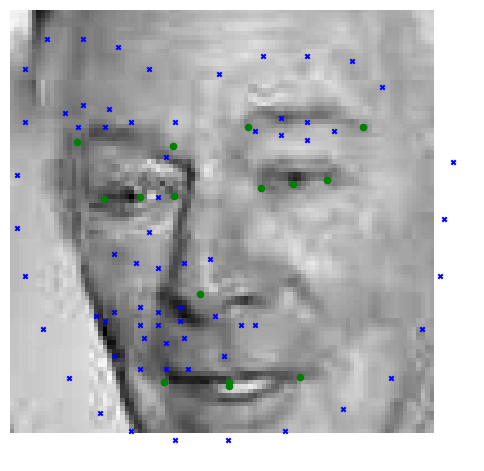

In [10]:
results.sort(key=lambda x: x[1:])
best = results[:3]
worst = results[-3:]

for group, title in (
    (best, "Best Predictions"), (worst, "Worst Predictions")
):
    print(title)
    for item in group:
        i, rmse, mae, nme, pck, mean_shift_x, mean_shift_y = item
        print(f"Image {i}")
        print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, NME: {nme:.3f}")
        print(f"PCK: {pck:.3f}")
        print(f"Mean shift X: {mean_shift_x:.3f}, Mean shift Y: {mean_shift_y:.3f}")

        image = df.loc[i]["image_r"]
        detected_landmarks = detect_landmarks(image)
        control_points = [
            (df.loc[i][feature], df.loc[i][feature.replace("_x", "_y")])
            for feature in df.columns[:-2:2]
        ]
        visualize_samples(image, detected_landmarks, control_points)

### Заметки из процесса выполнения задания
##### первая итерация
* По началу использовала для выбора лучшего/худшего изображения все метрики
* Так как средне квадратичная ошибка в целом имеет большие значения она вносит больший вклад в сортировку
* Подумать, какие из метрик оценок важнее для нас в конкретном случае и увеличить их вклад в выбор лучшего/худшего предсказания с использованием коэффициентов или вообще использовать только некоторые из них

##### To Do к второй итерация
* Шифт отрицательный по всем изображениям?
* Какие значения для PCK есть?
* Учитывать pck?
* Учитывать rmse or nme?  

In [11]:
set([item[4] for item in results if item[4] != 0])

{0.06666666666666667, 0.13333333333333333, 0.2}

In [12]:
[item[5:] for item in results if item[5] > 0 and item[6] > 0]

[]

 #### вторая итерация
 * Решила не учитывать вклад шифта в выбор лучшего/худшего предсказания, потому что он примерно одинаков и имеет один знак
 * О чем это говорит? Что используемая модель предсказывает в основном точки левее и выше, чем ожидается. Что нужно сделать? Подтюнить используемую модель, учитывая эти характеристики
 * Остальные метрики было решено нормализировать и уже потом сортировать результаты по ним

Best Predictions
Image 263
RMSE: 2.380, MAE: 1.812, NME: 0.324
PCK: 0.200
Mean shift X: -46.498, Mean shift Y: -44.222


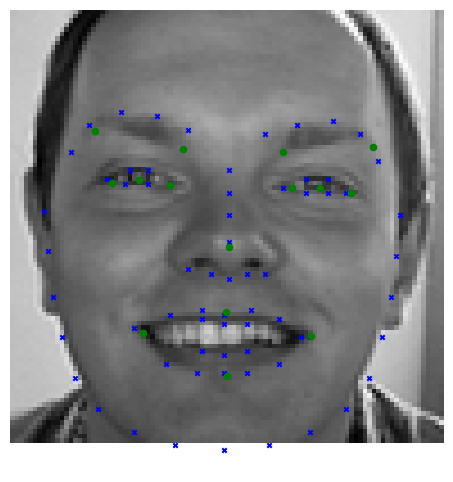

Image 73
RMSE: 2.786, MAE: 2.097, NME: 0.325
PCK: 0.200
Mean shift X: -48.699, Mean shift Y: -41.028


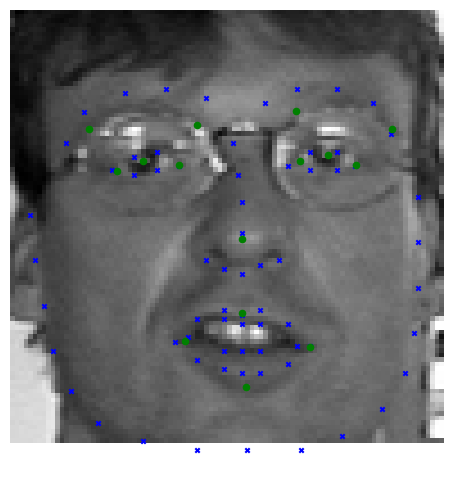

Image 2177
RMSE: 2.464, MAE: 1.994, NME: 0.415
PCK: 0.200
Mean shift X: -47.286, Mean shift Y: -44.468


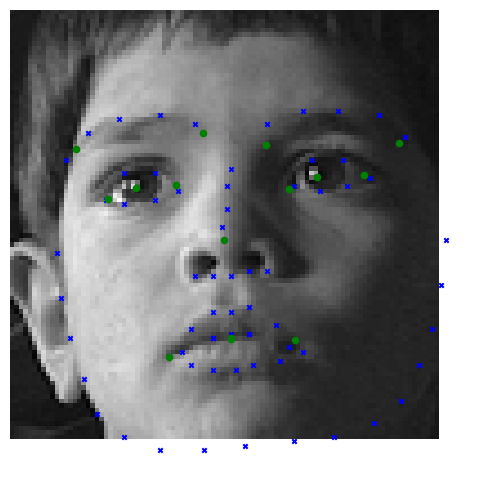

Image 1951
RMSE: 1.807, MAE: 1.370, NME: 0.337
PCK: 0.133
Mean shift X: -44.234, Mean shift Y: -47.125


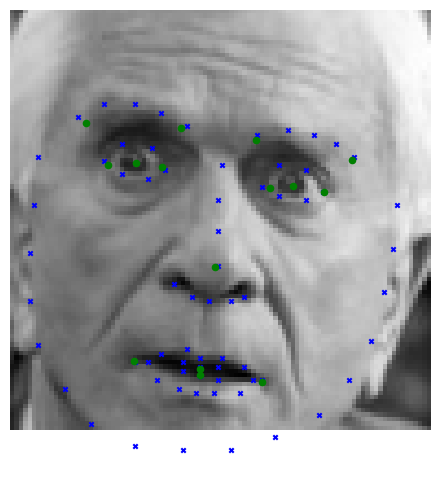

Image 1875
RMSE: 2.445, MAE: 1.907, NME: 0.298
PCK: 0.133
Mean shift X: -45.334, Mean shift Y: -49.252


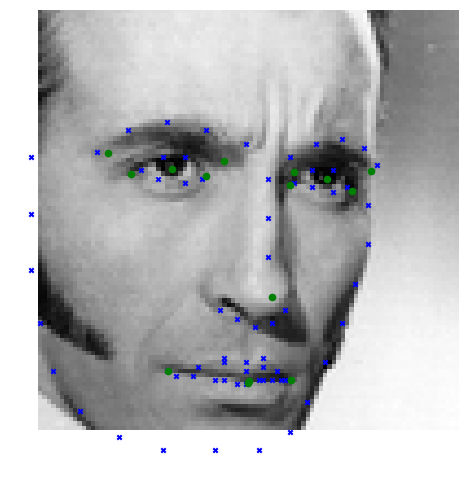

Worst Predictions
Image 1936
RMSE: 4.188, MAE: 3.684, NME: 0.552
PCK: 0.000
Mean shift X: -42.930, Mean shift Y: -42.871


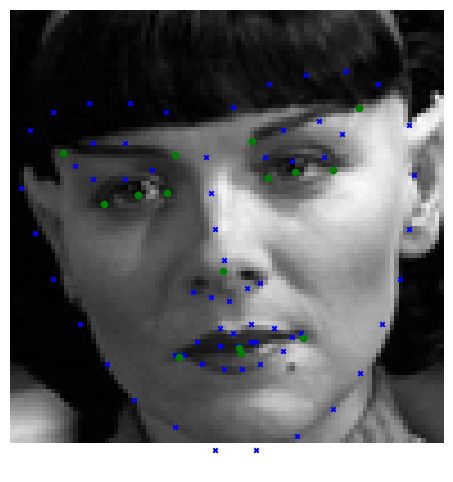

Image 1247
RMSE: 2.421, MAE: 2.292, NME: 0.700
PCK: 0.000
Mean shift X: -43.977, Mean shift Y: -44.537


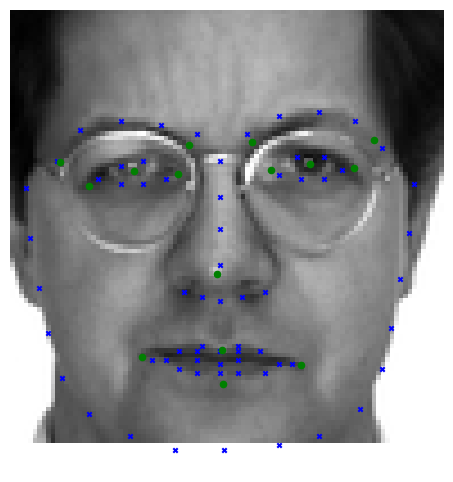

Image 597
RMSE: 2.644, MAE: 2.468, NME: 0.685
PCK: 0.000
Mean shift X: -46.108, Mean shift Y: -44.675


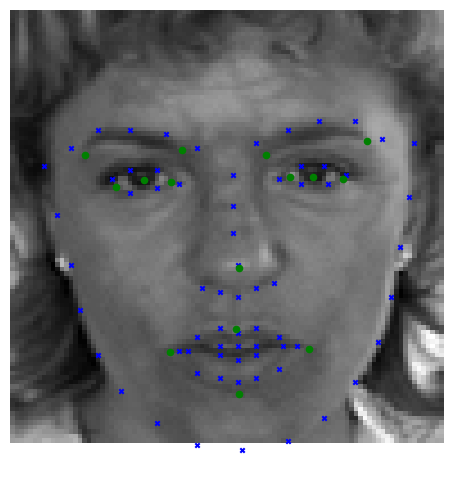

Image 166
RMSE: 2.410, MAE: 2.345, NME: 0.756
PCK: 0.000
Mean shift X: -46.435, Mean shift Y: -44.268


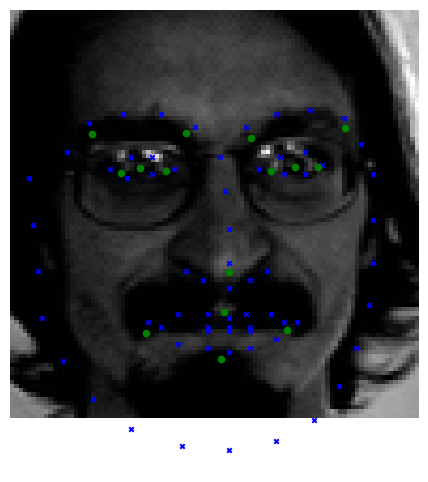

Image 1953
RMSE: 7.733, MAE: 6.809, NME: 0.531
PCK: 0.000
Mean shift X: -40.085, Mean shift Y: -43.512


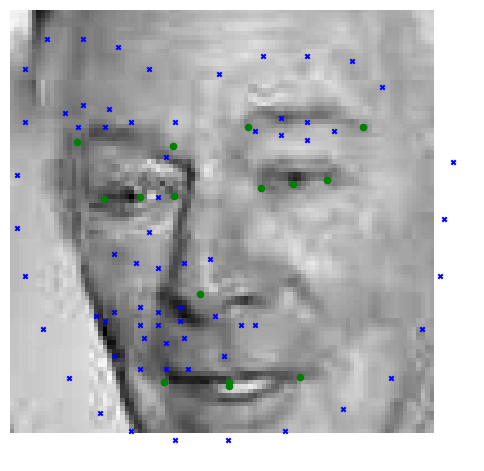

In [13]:
def normalize(value: float, min_val: float, max_val: float) -> float:
    return (value - min_val) / (max_val - min_val)


def compute_overall_score(
    rmse: float, nme: float, pck: float,
    min_rmse: float, max_rmse: float,
    min_nme: float, max_nme: float,
    min_pck: float, max_pck: float,
) -> float:
    norm_rmse = normalize(rmse, min_rmse, max_rmse)
    norm_nme = normalize(nme, min_nme, max_nme)
    norm_pck = 1 - normalize(pck, min_pck, max_pck)

    # можно использовать веса, но тут нужно поинвестигейтить,
    # чтобы понимать, какие веса использовать
    return sum((norm_rmse, norm_nme, norm_pck))


all_rmse = [item[1] for item in results]
all_nme = [item[3] for item in results]
all_pck = [item[4] for item in results]
min_rmse, max_rmse = min(all_rmse), max(all_rmse)
min_nme, max_nme = min(all_nme), max(all_nme)
min_pck, max_pck = min(all_pck), max(all_pck)

results.sort(
    key=lambda x: compute_overall_score(
        x[1], x[3], x[4],
        min_rmse, max_rmse,
        min_nme, max_nme,
        min_pck, max_pck,
    )
)
best = results[:5]
worst = results[-5:]

for group, title in (
    (best, "Best Predictions"), (worst, "Worst Predictions")
):
    print(title)
    for item in group:
        i, rmse, mae, nme, pck, mean_shift_x, mean_shift_y = item
        print(f"Image {i}")
        print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, NME: {nme:.3f}")
        print(f"PCK: {pck:.3f}")
        print(f"Mean shift X: {mean_shift_x:.3f}, Mean shift Y: {mean_shift_y:.3f}")

        image = df.loc[i]["image_r"]
        detected_landmarks = detect_landmarks(image)
        control_points = [
            (df.loc[i][feature], df.loc[i][feature.replace("_x", "_y")])
            for feature in df.columns[:-2:2]
        ]
        visualize_samples(image, detected_landmarks, control_points)

In [24]:
import json

worst_images = {}
for item in worst:
    id_ = item[0]
    image = df.loc[id_]["image_r"]
    landmarks = detect_landmarks(image)
    worst_images[id_] = {"landmarks": landmarks }

with open("worst_images.json", "w") as fw:
    json.dump(worst_images, fw)